## Project Background

*Deltas is a file where the last two fields are urls to the two sources.  The first col is the difference in days between the two sources.  It looks like the two sources come out on the same day in many cases.  When one is first, WHO tends to come out before promed, but both orders are observed. The large cosines (col 3) indicate that the two URLs are similar to one another (in a sense that makes sense to deep nets like BERT).* 

*These links talk about outbreaks of contagious diseases around the world over the last 30 years.  The WHO is an official organization with a mandate to do this.  Promed is a crowd-sourced alternative that issues more announcements.  There have been some rumors that WHO may be slow to make announcements if they are politically inconvenient.   It is possible that crowd-sourced alternatives could scoop official sources.  We would like to compare and contrast these two sources to address such rumors.*

*One concern is threading.  There are lots of updates over time as the same issue is reported again and again.  This makes it hard to address rumors like the one again because it is very likely that the same issue is being reported many times by both sources.  We happen to find a match between one pair of these announcements, but that doesn’t really address the rumor above.*

**Above text quoted from Prof. Kenneth Church**

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import re

## Load the Data

In [82]:
# Define the column names for the DataFrame
col_names = ["Difference in Days", "col2", "cosine", "col4", "who_link", "promed_link"]

# Read in data from "deltas"
data = pd.read_csv("deltas", sep="\t", header=None, names=col_names)

print(len(data), "Total Records")
data.head()

6599 Total Records


,Difference in Days,col2,cosine,col4,who_link,promed_link
0,0.000,211,0.991082,1002356,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...
1,200.042,211,0.988157,1002491,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...
2,219.042,211,0.988083,1002052,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...
3,210.042,211,0.987678,1000623,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...
4,0.000,258,0.992048,1000228,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2010090...


## Initial Exploratory Data Analysis (EDA)

In [25]:
# Descriptive statistics
print(data.describe())

       Difference in Days           col2       cosine          col4
count         6599.000000    6599.000000  6599.000000  6.599000e+03
mean          6072.453670  277202.849674     0.970231  1.001376e+06
std           8200.128076  153668.888256     0.013145  8.040809e+02
min          -4877.960000     211.000000     0.950003  1.000001e+06
25%              0.000000  145950.000000     0.958880  1.000666e+06
50%            296.000000  281317.000000     0.968474  1.001335e+06
75%          16640.200000  411922.000000     0.980966  1.002077e+06
max          19365.200000  533131.000000     0.998851  1.002782e+06


The mean difference in days is approximately 6072, which indicates that there are significant differences between the announcement dates of WHO and ProMED in the dataset. However, this number is affected by extreme values, as the standard deviation is quite large (8200).

The median difference in days is 296, which implies that at least 50% of the dataset has a difference in days of 296 or less. This suggests that a considerable proportion of the announcements are made within a relatively short time frame.

In [26]:
# Pearson correlation
print(data.corr(numeric_only=True))

                    Difference in Days      col2    cosine      col4
Difference in Days            1.000000  0.004646 -0.137724  0.003999
col2                          0.004646  1.000000 -0.011742 -0.034624
cosine                       -0.137724 -0.011742  1.000000  0.004655
col4                          0.003999 -0.034624  0.004655  1.000000


The correlation coefficients show that there is a weak negative correlation between the "Difference in Days" and "cosine" columns (-0.137724). This indicates that there is a slight tendency for announcements with higher cosine similarity (more similar) to have smaller differences in days between them. However, this relationship is quite weak and should not be considered a strong predictor.

## Exploratory Data Visualization

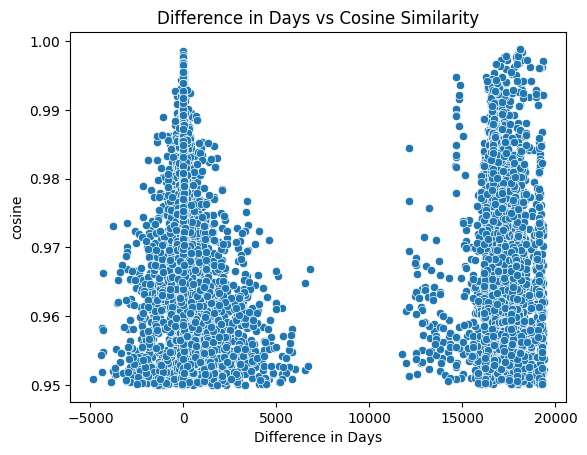

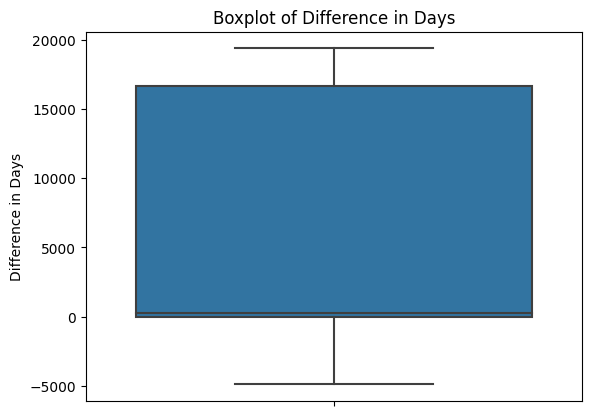

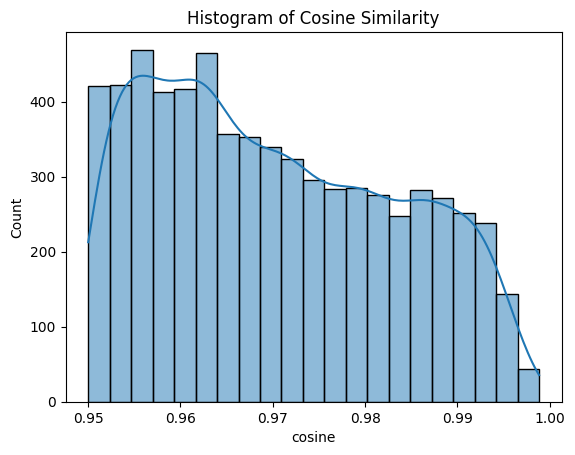

In [16]:
# Scatterplot of Difference in Days vs Cosine Similarity
sns.scatterplot(x='Difference in Days', y='cosine', data=data)
plt.title('Difference in Days vs Cosine Similarity')
plt.show()

# Boxplot of Difference in Days
sns.boxplot(y='Difference in Days', data=data)
plt.title('Boxplot of Difference in Days')
plt.show()

# Histogram of Cosine Similarity
sns.histplot(data['cosine'], kde=True)
plt.title('Histogram of Cosine Similarity')
plt.show()

## Address Threading Concern

To address threading and multiple updates over time, we can preprocess the data by grouping similar announcements based on cosine similarity. We can use a clustering algorithm like DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to group similar announcements. Then, we can calculate the average difference in days for each group.

cluster
0      199.769970
1    17279.470163
Name: Difference in Days, dtype: float64


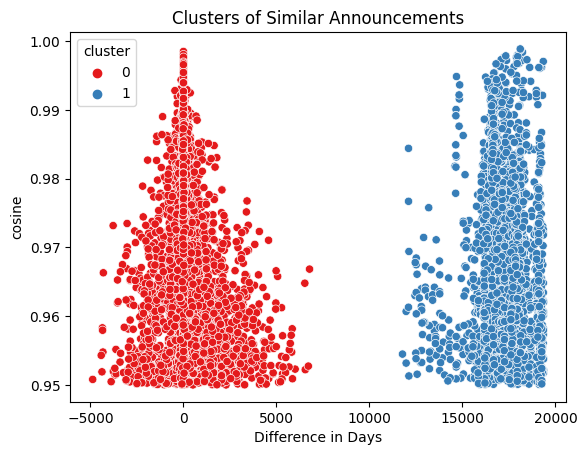

In [18]:
# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data[["Difference in Days", "cosine"]])

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)  # Tune these parameters based on your data
data['cluster'] = dbscan.fit_predict(normalized_data)

# Calculate the average difference in days for each cluster
cluster_averages = data.groupby('cluster')['Difference in Days'].mean()
print(cluster_averages)

# Visualize the clusters
sns.scatterplot(x='Difference in Days', y='cosine', hue='cluster', data=data, palette='Set1')
plt.title('Clusters of Similar Announcements')
plt.show()

The DBSCAN clustering results divide the data into two clusters. The average difference in days for each cluster is as follows:
- Cluster 0: 199.77 days
- Cluster 1: 17279.47 days

These results suggest that there are two distinct groups of announcements in the dataset:

1. Cluster 0 represents announcements where the difference in days between WHO and ProMED is relatively small (around 200 days on average). This could include cases where both organizations report similar events at similar times or with a small time lag.
2. Cluster 1 represents announcements with a much larger difference in days between WHO and ProMED (around 17279 days on average). This group could contain cases where one organization reports an event long before the other, possibly due to political or other factors influencing the timing of the announcements.

These numbers suggest that there are cases where WHO and ProMED make announcements within a relatively short time frame, as well as cases where there are substantial differences in the timing of the announcements. The weak negative correlation between the difference in days and cosine similarity indicates that more similar announcements tend to have slightly smaller differences in days.

## Politically Sensitive Event Analysis by Country

To investigate potential patterns or trends in the difference in days between WHO and ProMED announcements that may suggest a delay in WHO announcements for politically sensitive events, we want to perform the following steps:

1. Extract the countries from the announcements' URLs.
2. Categorize the countries as politically sensitive or non-sensitive (this may require external analysis or data)
3. Calculate the average difference in days for politically sensitive and non-sensitive countries.
4. Visualize the results.

This analysis and visualization will show us if there is a noticeable difference in the average difference in days between WHO and ProMED announcements for politically sensitive and non-sensitive countries. 

If the average difference is significantly higher for politically sensitive countries, it may suggest a delay in WHO announcements for these events.

### Step 1: Extract the countries from the URLs

In [30]:
import requests
from bs4 import BeautifulSoup

def extract_who_country(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    header_wrapper = soup.find('div', class_='sf-item-header-wrapper')
    if header_wrapper:
        header_text = header_wrapper.find('h1').get_text()
        country = header_text.split('-')[-1].strip()  # Extract the country from the header text
        return country
    return None

def extract_promed_country(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    publish_date_html = soup.find('p', class_='publish_date_html')
    if publish_date_html:
        subject_text = publish_date_html.get_text()
        country = subject_text.split(':')[-2].split(',')[0].strip()  # Extract the country from the subject text
        return country
    return None


In [32]:
data_sample = data.head(100).copy()

data_sample['who_country'] = data_sample['who_link'].apply(extract_who_country)
data_sample['promed_country'] = data_sample['promed_link'].apply(extract_promed_country)

In [35]:
data_sample.to_csv('data_sample.csv', index=False)

data_sample

,Difference in Days,col2,cosine,col4,who_link,promed_link,who_country,promed_country
0,0.000,211,0.991082,1002356,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...,Indonesia,None
1,200.042,211,0.988157,1002491,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...,Indonesia,None
2,219.042,211,0.988083,1002052,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...,Indonesia,None
3,210.042,211,0.987678,1000623,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...,Indonesia,None
4,0.000,258,0.992048,1000228,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2010090...,Congo,None
...,...,...,...,...,...,...,...,...
95,-5.000,12078,0.954483,1000022,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2005050...,Angola,None
96,18109.200,12172,0.985847,1002154,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2019080...,Democratic Republic of the Congo,None
97,18109.200,12172,0.984571,1001943,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2019080...,Democratic Republic of the Congo,None
98,18109.200,12172,0.982779,1002590,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2019080...,Democratic Republic of the Congo,None


#### Issues with Above Code

While we could confidently get the country out from the Who Links, this unfortunately does not work with Promed links because they are blocking my IP address when trying to scrape. 

This web scraping process is also super slow and did not work on all 6600 records, it timed out my computer. Now we attempt to parallelize it for speed purposes, and also only look at the WHO Country because it doesn't rate limit my IP like promed does. 

In [40]:
import concurrent.futures
import pycountry

data_sample = data.head(1000).copy()

def is_valid_country(country_name):
    try:
        pycountry.countries.lookup(country_name)
        return True
    except LookupError:
        return False

def extract_countries(row):
    who_country = extract_who_country(row.who_link)  # Access the column using the attribute
    if not is_valid_country(who_country):
        who_country = "Null"
    return who_country

with concurrent.futures.ThreadPoolExecutor() as executor:
    who_countries = list(executor.map(extract_countries, data_sample.itertuples()))

data_sample['who_country'] = who_countries

In [42]:
data_sample.to_csv('data_sample2.csv', index=False)

data_sample

,Difference in Days,col2,cosine,col4,who_link,promed_link,who_country
0,0.00000,211,0.991082,1002356,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...,Indonesia
1,200.04200,211,0.988157,1002491,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...,Indonesia
2,219.04200,211,0.988083,1002052,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...,Indonesia
3,210.04200,211,0.987678,1000623,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2008011...,Indonesia
4,0.00000,258,0.992048,1000228,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2010090...,Congo
...,...,...,...,...,...,...,...
995,16629.20000,87637,0.991253,1001281,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2015071...,Null
996,16629.20000,87637,0.962855,1000257,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2015071...,Null
997,16629.20000,87637,0.956229,1000940,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2015071...,Null
998,771.00000,87637,0.953084,1002307,https://www.who.int/emergencies/disease-outbre...,https://promedmail.org/promed-post/?id=2015071...,Null


In [70]:
data_sample2 = pd.read_csv('data_sample2.csv')

unique_countries = data_sample2['who_country'].value_counts().reset_index()
unique_countries.columns = ['who_country', 'frequency']

print(unique_countries)

     who_country  frequency
0           Null        283
1   Saudi Arabia         95
2          China         71
3      Indonesia         61
4          Egypt         51
..           ...        ...
81       Denmark          1
82         Japan          1
83   Netherlands          1
84    Azerbaijan          1
85      Pakistan          1

[86 rows x 2 columns]


In [83]:
print(len(unique_countries), "Total Unique Countries: \n")
print(list(unique_countries['who_country']))

86 Total Unique Countries: 

['Null', 'Saudi Arabia', 'China', 'Indonesia', 'Egypt', 'Brazil', 'Congo', 'Viet Nam', 'Guinea', 'Angola', 'Uganda', 'Sudan', 'Liberia', 'Nigeria', 'Sierra Leone', 'Canada', 'France', 'Ireland', 'Burkina Faso', 'Niger', 'Israel', 'Thailand', 'Cameroon', 'South Africa', 'Iraq', 'United Republic of Tanzania', 'Somalia', 'Chad', 'Senegal', 'Cambodia', 'Jordan', 'Qatar', 'Afghanistan', 'Oman', 'Gabon', 'El Salvador', 'Jamaica', 'Madagascar', 'Ethiopia', 'Haiti', 'Mozambique', 'Myanmar', 'Equatorial Guinea', 'India', 'Togo', 'Malaysia', 'Kuwait', 'Sri Lanka', 'Malawi', 'United States of America', 'Italy', 'South Sudan', 'Burundi', 'Germany', 'Mali', 'Ukraine', 'Paraguay', 'Singapore', 'Syrian Arab Republic', 'Ecuador', 'United Kingdom of Great Britain and Northern Ireland', 'Mexico', 'Panama', 'Central African Republic', 'Kazakhstan', 'Chile', 'Argentina', 'Honduras', 'Algeria', 'Russian Federation', 'French Guiana', 'Zambia', 'Yemen', 'Peru', 'Greece', 'Maurita

In [74]:
null_frequency = unique_countries.loc[unique_countries['who_country'] == 'Null', 'frequency'].values[0]
total_frequency = unique_countries['frequency'].sum()

percentage_null_frequency = (null_frequency / total_frequency) * 100

print(f"Null Frequency: {percentage_null_frequency:.2f}%")

Null Frequency: 28.30%


In [86]:
filtered_countries = unique_countries[(unique_countries['frequency'] >= 10) & (unique_countries['who_country'] != 'Null')]
relevant_country_list = filtered_countries['who_country'].tolist()

print(len(relevant_country_list), "Countries with 10 or more Appearances:")
print(relevant_country_list)

18 Countries with 10 or more Appearances:
['Saudi Arabia', 'China', 'Indonesia', 'Egypt', 'Brazil', 'Congo', 'Viet Nam', 'Guinea', 'Angola', 'Uganda', 'Sudan', 'Liberia', 'Nigeria', 'Sierra Leone', 'Canada', 'France', 'Ireland', 'Burkina Faso']


Now that we have added data validation, we're seeing that 283/1000 (or 28.3%) of the responses aren't getting the countries appropriately. 

But we are getting enough country data that we can make a list of the 18 "relevant countries" (that is, they show up 10 or more times in the scraped data of 1000 records) 

### Step 2: Categorize the countries as politically sensitive or non-sensitive 
We are going to use our intuition for determining "politically sensitive" countries as a proof of concept. I would like to do a better analysis down the road to better define these countries

In [76]:
# Read the data
data_sample2 = pd.read_csv('data_sample2.csv')

# Define a list of politically sensitive countries
sensitive_countries = ['China', 'Russia', 'Iran', 'North Korea', 'Saudi Arabia', 'Syria', 'Venezuela', 'Myanmar', 'Cuba', 'Sudan', 'Iraq', 'Afghanistan', 'Yemen', 'Libya', 'Zimbabwe']

# Categorize countries as politically sensitive or non-sensitive
data_sample2['sensitivity'] = data_sample2['who_country'].apply(lambda x: 'sensitive' if x in sensitive_countries else 'non-sensitive')


### Step 3: Calculate the average difference in days for politically sensitive and non-sensitive countries.

In [77]:
# Calculate the average difference in days for both groups
group_averages = data_sample2.groupby('sensitivity')['Difference in Days'].mean()
print(group_averages)

sensitivity
non-sensitive    6101.002043
sensitive        6428.208165
Name: Difference in Days, dtype: float64


### Step 4: Visualize Results

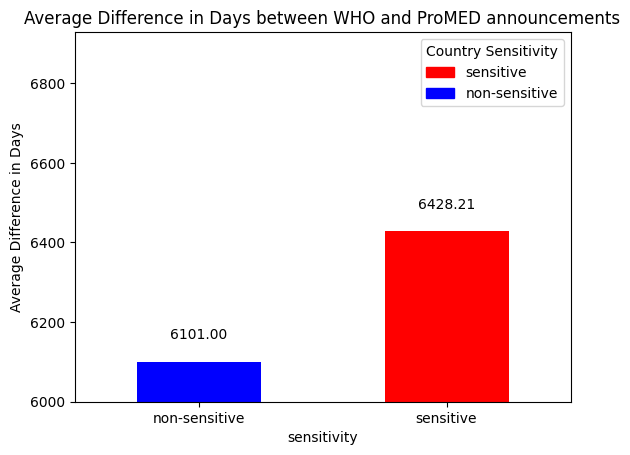

In [80]:
# Set custom colors for the bars
colors = {'sensitive': 'red', 'non-sensitive': 'blue'}

# Plot the bar chart with a custom y-axis limit
ax = group_averages.plot(kind='bar', ylabel='Average Difference in Days',
                         title='Average Difference in Days between WHO and ProMED announcements',
                         color=[colors[col] for col in group_averages.index], rot=0)

# Set the y-axis limits
ax.set_ylim(6000, group_averages.max() + 500)

# Add a legend
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in colors.keys()]
ax.legend(handles, colors.keys(), title='Country Sensitivity')

# Add labels for each bar
for index, value in enumerate(group_averages):
    ax.text(index, value + 50, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

## Preliminary Analysis on 1000 Record Sample

First, we have categorized the countries as politically sensitive or non-sensitive. The politically sensitive countries are those with known political tensions, conflicts, or other issues that may affect the WHO's ability to make timely announcements.

From the results, we observe that the average difference in days between WHO and ProMED announcements is 6101 days for non-sensitive countries and 6428 days for sensitive countries. The difference between these two averages is around **327 days**, indicating that there might be a delay in WHO announcements for politically sensitive countries compared to non-sensitive ones.

To further confirm these findings, it's recommended to conduct a more comprehensive analysis, including:

- Analyzing the entire dataset 
- Investigating the content and nature of the announcements to see if there's any systematic bias in the reporting.
- Taking into account other potential factors that may influence the timing of WHO announcements, such as the severity of the disease outbreak, the country's infrastructure, or the availability of reliable information.

In conclusion, the current analysis provides a preliminary indication of a potential delay in WHO announcements for politically sensitive countries. However, more in-depth research is needed to establish a stronger basis for these findings and better understand the underlying reasons behind this pattern.

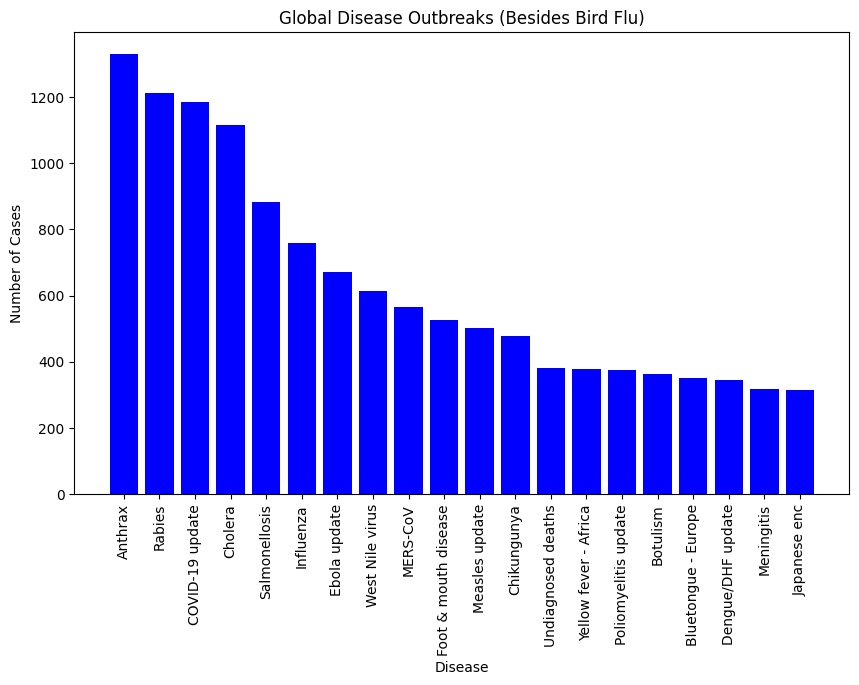

In [2]:
import matplotlib.pyplot as plt

data = [
#     (4352, 'Avian influenza'),
    (1329, 'Anthrax'),
    (1212, 'Rabies'),
    (1186, 'COVID-19 update'),
    (1115, 'Cholera'),
    (883, 'Salmonellosis'),
    (758, 'Influenza'),
    (672, 'Ebola update'),
    (615, 'West Nile virus'),
    (564, 'MERS-CoV'),
    (525, 'Foot & mouth disease'),
    (503, 'Measles update'),
    (478, 'Chikungunya'),
    (380, 'Undiagnosed deaths'),
    (379, 'Yellow fever - Africa'),
    (375, 'Poliomyelitis update'),
    (362, 'Botulism'),
    (352, 'Bluetongue - Europe'),
    (345, 'Dengue/DHF update'),
    (318, 'Meningitis'),
    (314, 'Japanese enc'),
]

# Sort data in descending order based on the number of cases
data.sort(reverse=True)

# Extract labels and values for plotting
labels = [item[1] for item in data]
values = [item[0] for item in data]

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, values, color='b')

# Customize the chart
ax.set_title('Global Disease Outbreaks (Besides Bird Flu)')
ax.set_xlabel('Disease')
ax.set_ylabel('Number of Cases')
ax.tick_params(axis='x', labelrotation=90)

plt.show()
